**#IMPORT LIBRARIES**

In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore
import os
import cv2
import numpy as np
import shutil
from PIL import Image
from collections import defaultdict
import hashlib
from collections import Counter

**#DATASET ANALYSIS
1.1 class distribution**

In [37]:
# Dataset analysis
DATASET_DIR = "disease/train"
class_counts = {}
for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        class_counts[class_name] = len(images)

print("----------------------Class Distribution:--------------------------\n")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Total images and classes calculation
total_images = sum(class_counts.values())
n_classes = len(class_counts)
print(f"\n----------------------------------Dataset Summary:-----------------------")
print(f"Total images: {total_images}")
print(f"Number of classes: {n_classes}")
print(f"Average images per class: {total_images/n_classes:.1f}")


----------------------Class Distribution:--------------------------

Apple___Apple_scab: 2016 images
Apple___Black_rot: 2027 images
Apple___Cedar_apple_rust: 1760 images
Apple___healthy: 2008 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 1642 images
Corn_(maize)___Common_rust_: 1948 images
Corn_(maize)___healthy: 1859 images
Corn_(maize)___Northern_Leaf_Blight: 1908 images
Pepper,_bell___Bacterial_spot: 1913 images
Pepper,_bell___healthy: 1988 images
Potato___Early_blight: 1939 images
Potato___healthy: 1824 images
Potato___Late_blight: 1939 images
Tomato___Bacterial_spot: 1702 images
Tomato___Early_blight: 1920 images
Tomato___healthy: 1926 images
Tomato___Late_blight: 1851 images
Tomato___Leaf_Mold: 1882 images
Tomato___Septoria_leaf_spot: 1745 images
Tomato___Spider_mites Two-spotted_spider_mite: 1741 images
Tomato___Target_Spot: 1827 images
Tomato___Tomato_mosaic_virus: 1790 images
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1961 images

----------------------------------Da

**#MIN AND MAX CLASSES**

In [38]:
# Find min and max class sizes
min_images = min(class_counts.values())
max_images = max(class_counts.values())
min_class_name = min(class_counts, key=class_counts.get)
max_class_name = max(class_counts, key=class_counts.get)
print(f"Smallest class \n{min_class_name}=> {min_images} images\n")
print(f"Largest class \n{max_class_name}=> {max_images} images\n")


Smallest class 
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot=> 1642 images

Largest class 
Apple___Black_rot=> 2027 images



**#IMAGE COUNT PER CLASS**

In [39]:
print("-------------------Counting images in each class----------------------------------")
image_extensions=('.jpg', '.jpeg', '.png')      
for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) 
        if f.lower().endswith(image_extensions)]
        class_counts[class_name] = len(images)
print(class_counts)

-------------------Counting images in each class----------------------------------
{'Apple___Apple_scab': 2016, 'Apple___Black_rot': 2027, 'Apple___Cedar_apple_rust': 1760, 'Apple___healthy': 2008, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 1642, 'Corn_(maize)___Common_rust_': 1948, 'Corn_(maize)___healthy': 1859, 'Corn_(maize)___Northern_Leaf_Blight': 1908, 'Pepper,_bell___Bacterial_spot': 1913, 'Pepper,_bell___healthy': 1988, 'Potato___Early_blight': 1939, 'Potato___healthy': 1824, 'Potato___Late_blight': 1939, 'Tomato___Bacterial_spot': 1702, 'Tomato___Early_blight': 1920, 'Tomato___healthy': 1926, 'Tomato___Late_blight': 1851, 'Tomato___Leaf_Mold': 1882, 'Tomato___Septoria_leaf_spot': 1745, 'Tomato___Spider_mites Two-spotted_spider_mite': 1741, 'Tomato___Target_Spot': 1827, 'Tomato___Tomato_mosaic_virus': 1790, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 1961}


**#DESCRIPTIVE DATA ANALYIS**

In [40]:
# Dataset balance analysis
if class_counts: 
    counts = list(class_counts.values())
    total_images = sum(counts)
    n_classes = len(class_counts)
    
    analysis_results = {
        'total_images': total_images,
        'n_classes': n_classes,
        'average_per_class': total_images / n_classes,
        'min_images': min(counts),
        'max_images': max(counts),
        'std_dev': np.std(counts),
        'median': np.median(counts)
    }
    
    min_class = min(class_counts, key=class_counts.get)
    max_class = max(class_counts, key=class_counts.get)
    
    analysis_results['min_class'] = min_class
    analysis_results['max_class'] = max_class
    
    imbalance_ratio = analysis_results['max_images'] / analysis_results['min_images']
    analysis_results['imbalance_ratio'] = imbalance_ratio
    
    if imbalance_ratio < 2:
        balance_status = "Well Balanced"
    elif imbalance_ratio < 5:
        balance_status = "Slightly Imbalanced"
    elif imbalance_ratio < 10:
        balance_status = "Moderately Imbalanced"
    else:
        balance_status = "Severely Imbalanced"
    
    analysis_results['balance_status'] = balance_status
    
    print("--------------Analysis results------------------")
    print(analysis_results)
else:
    print("No classes found in the dataset!")


--------------Analysis results------------------
{'total_images': 43116, 'n_classes': 23, 'average_per_class': 1874.608695652174, 'min_images': 1642, 'max_images': 2027, 'std_dev': 103.5931587175586, 'median': 1908.0, 'min_class': 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'max_class': 'Apple___Black_rot', 'imbalance_ratio': 1.2344701583434836, 'balance_status': 'Well Balanced'}


**#VISUALISATION**

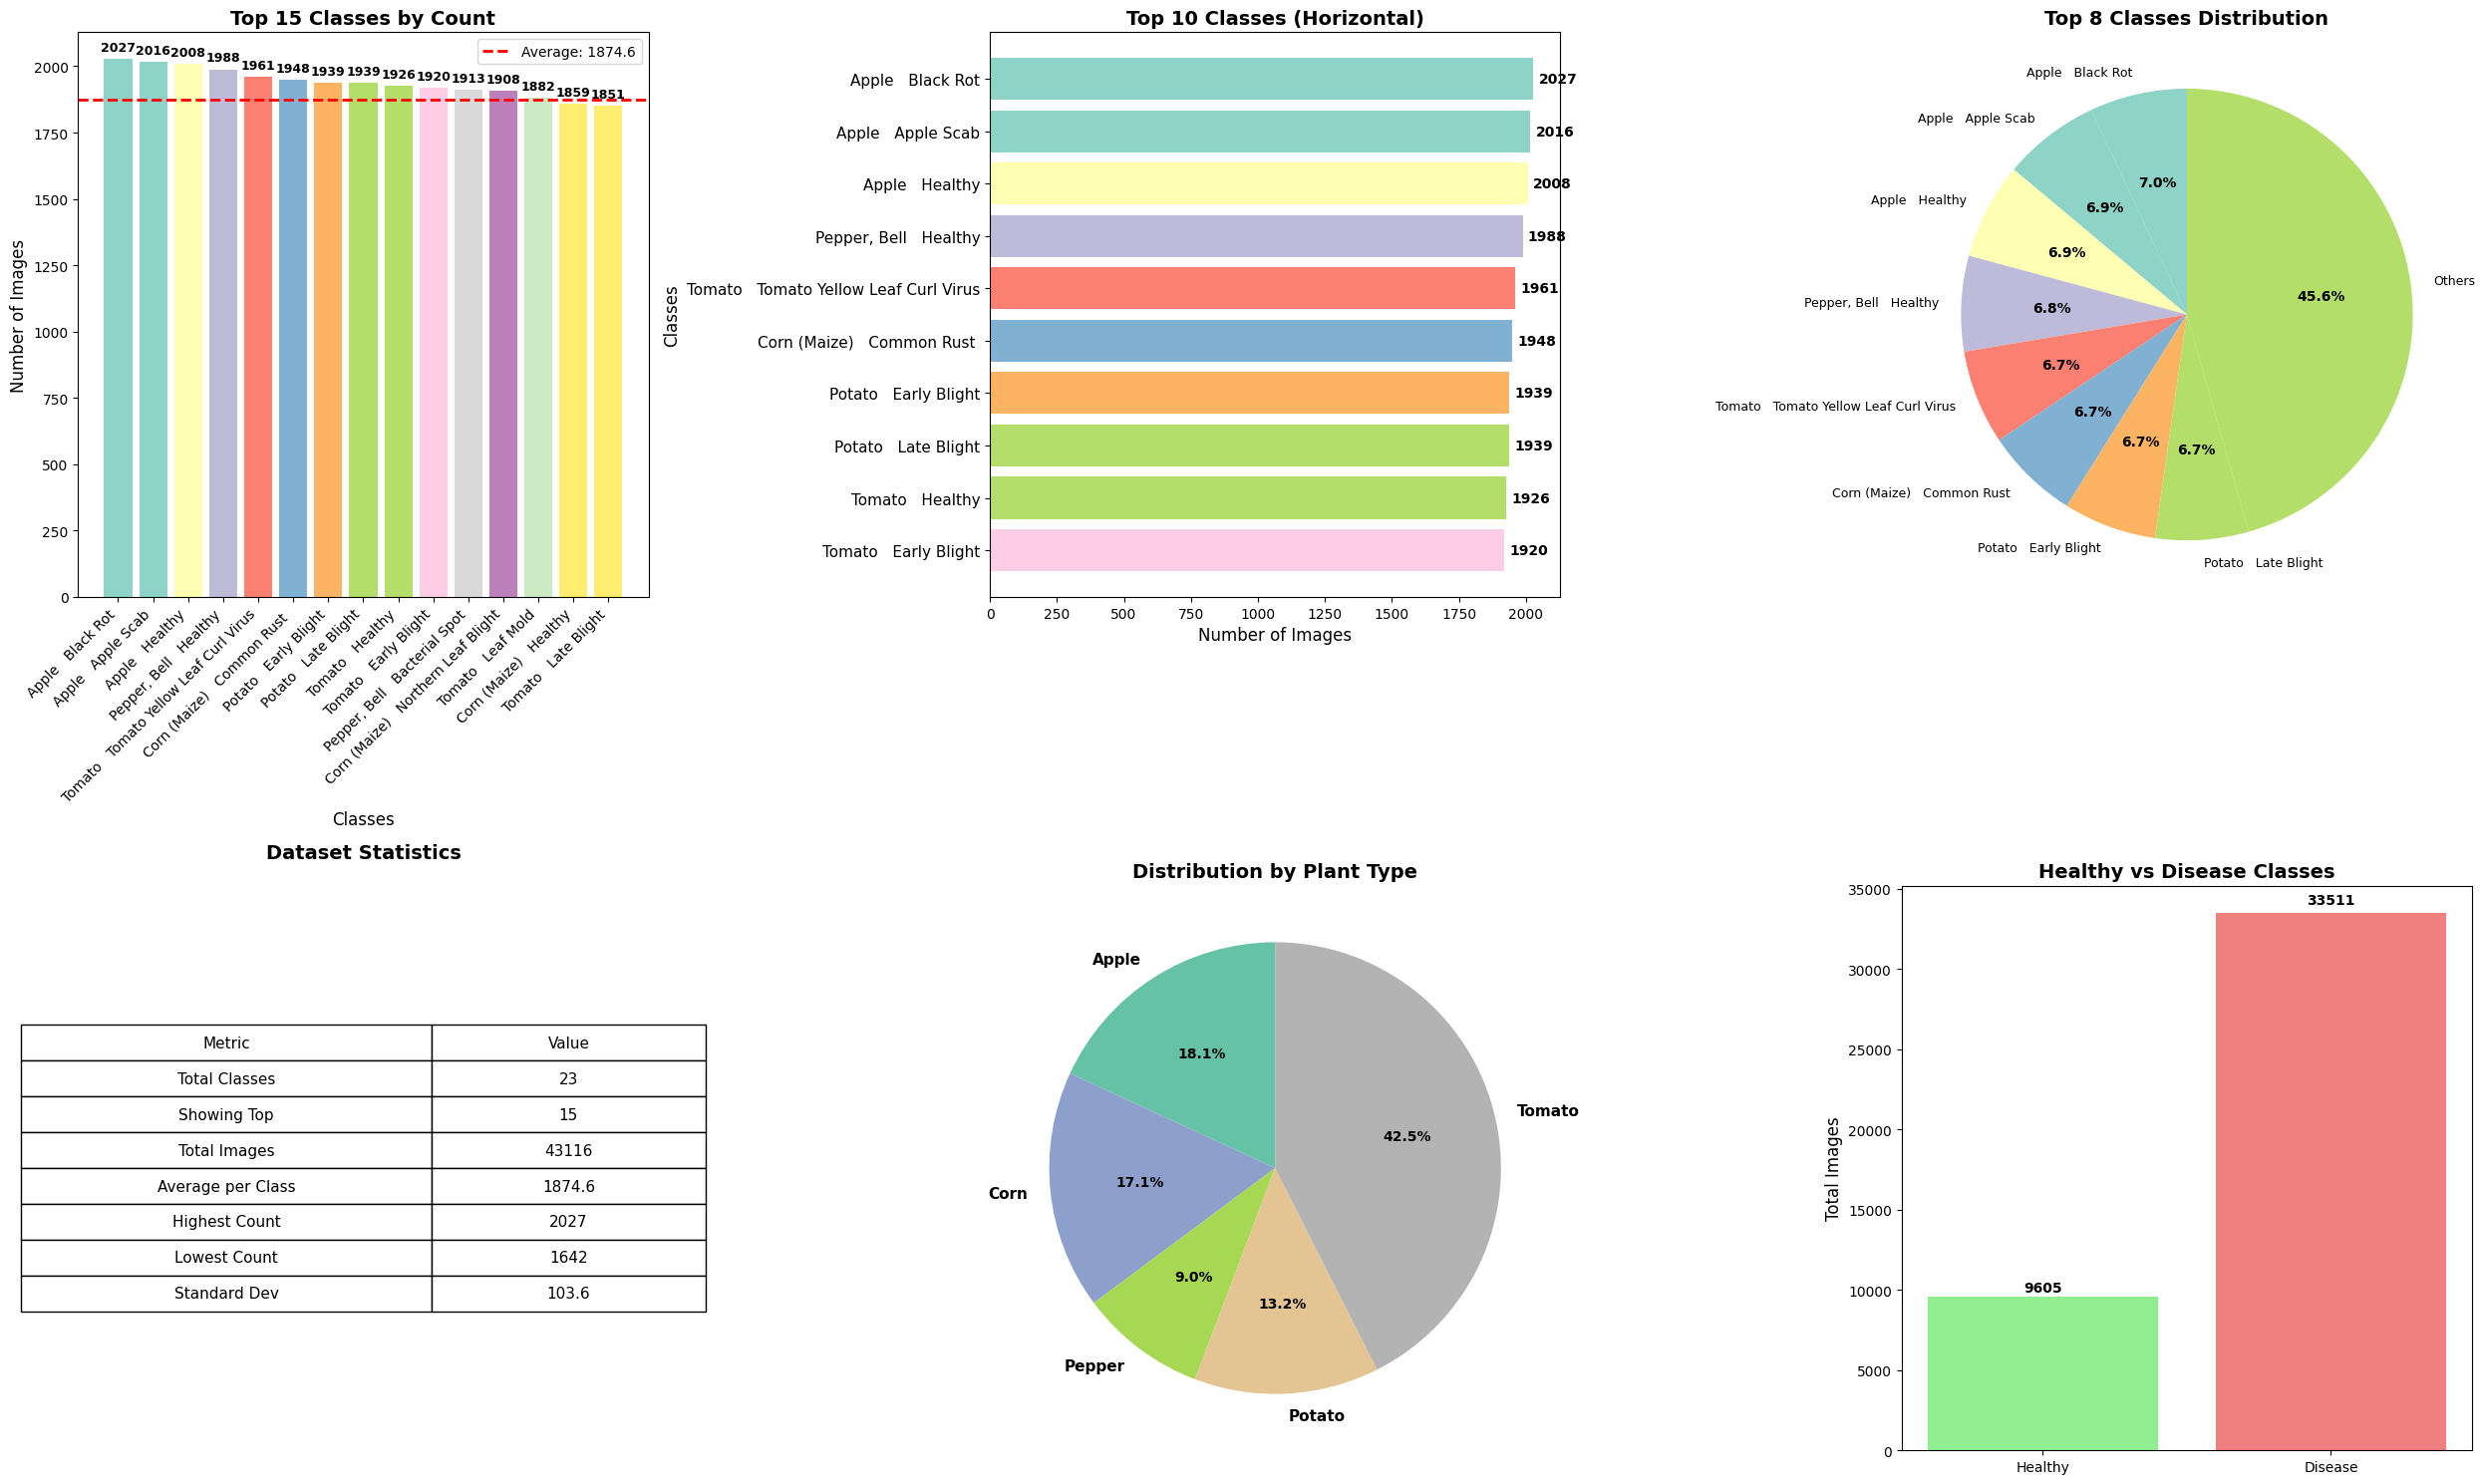

In [41]:
fig = plt.figure(figsize=(25, 15))

# Sort classes by count for better visualization(SHOW ONLY TOP 15)
sorted_classes = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True)[:15])
class_names = list(sorted_classes.keys())
class_values = list(sorted_classes.values())

# Clean up class names(better readability)
clean_class_names = [name.replace('_', ' ').title() for name in class_names]

# Color scheme
colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))

# Main bar plot - sorted by count (TOP 15 ONLY)
ax1 = plt.subplot(2, 3, 1)
bars1 = ax1.bar(range(len(class_names)), class_values, color=colors)
ax1.set_title('Top 15 Classes by Count', fontsize=14, fontweight='bold')
ax1.set_xlabel('Classes', fontsize=12)
ax1.set_ylabel('Number of Images', fontsize=12)
ax1.set_xticks(range(len(class_names)))
ax1.set_xticklabels(clean_class_names, rotation=45, ha='right', fontsize=10)

# value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
    f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)

#average line
avg_line = analysis_results['average_per_class']
ax1.axhline(y=avg_line, color='red', linestyle='--', linewidth=2, 
            label=f'Average: {avg_line:.1f}')
ax1.legend()

# Horizontal bar plot(TOP 10 ONLY)
ax2 = plt.subplot(2, 3, 2)
top_10_names = class_names[:10]
top_10_values = class_values[:10]
top_10_clean = clean_class_names[:10]

bars2 = ax2.barh(range(len(top_10_names)), top_10_values, color=colors[:10])
ax2.set_title('Top 10 Classes (Horizontal)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Images', fontsize=12)
ax2.set_ylabel('Classes', fontsize=12)
ax2.set_yticks(range(len(top_10_names)))
ax2.set_yticklabels(top_10_clean, fontsize=11)
ax2.invert_yaxis()  # Highest count at top

# Add value labels
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width + width*0.01, bar.get_y() + bar.get_height()/2.,
            f'{int(width)}', ha='left', va='center', fontweight='bold', fontsize=10)

# Pie chart (TOP 8 ONLY )
ax3 = plt.subplot(2, 3, 3)
top_8_names = clean_class_names[:8]
top_8_values = class_values[:8]
other_sum = sum(class_values[8:])

if other_sum > 0:
    pie_names = top_8_names + ['Others']
    pie_values = top_8_values + [other_sum]
else:
    pie_names = top_8_names
    pie_values = top_8_values

wedges, texts, autotexts = ax3.pie(pie_values, labels=pie_names, autopct='%1.1f%%',
                                   colors=colors[:len(pie_values)], startangle=90)
ax3.set_title('Top 8 Classes Distribution', fontsize=14, fontweight='bold')

# Make percentage text bold and adjust font size
for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

# Adjust label font size
for text in texts:
    text.set_fontsize(9)

# Statistics summary
ax4 = plt.subplot(2, 3, 4)
ax4.axis('off')

# Create a clean statistics table
stats_data = [
    ['Total Classes', len(class_counts)],
    ['Showing Top', len(class_names)],
    ['Total Images', sum(class_counts.values())],
    ['Average per Class', f'{analysis_results["average_per_class"]:.1f}'],
    ['Highest Count', max(class_counts.values())],
    ['Lowest Count', min(class_counts.values())],
    ['Standard Dev', f'{analysis_results.get("std_dev", 0):.1f}']
]

table = ax4.table(cellText=stats_data,
                  colLabels=['Metric', 'Value'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)

ax4.set_title('Dataset Statistics', fontsize=14, fontweight='bold', pad=20)

# Plant type grouping (if applicable)
ax5 = plt.subplot(2, 3, 5)
plant_groups = {}
for class_name, count in class_counts.items():
    if any(word in class_name.lower() for word in ['apple']):
        plant_type = 'Apple'
    elif any(word in class_name.lower() for word in ['tomato']):
        plant_type = 'Tomato'
    elif any(word in class_name.lower() for word in ['corn']):
        plant_type = 'Corn'
    elif any(word in class_name.lower() for word in ['potato']):
        plant_type = 'Potato'
    elif any(word in class_name.lower() for word in ['pepper']):
        plant_type = 'Pepper'
    else:
        plant_type = 'Other'
    
    if plant_type not in plant_groups:
        plant_groups[plant_type] = 0
    plant_groups[plant_type] += count

if len(plant_groups) > 1:
    wedges2, texts2, autotexts2 = ax5.pie(plant_groups.values(), 
                                          labels=plant_groups.keys(), 
                                          autopct='%1.1f%%',
                                          startangle=90,
                                          colors=plt.cm.Set2(np.linspace(0, 1, len(plant_groups))))
    ax5.set_title('Distribution by Plant Type', fontsize=14, fontweight='bold')
    
    for text in texts2:
        text.set_fontsize(11)
        text.set_fontweight('bold')
    for autotext in autotexts2:
        autotext.set_fontsize(10)
        autotext.set_fontweight('bold')
else:
    ax5.text(0.5, 0.5, 'Single Plant Type\nDataset', ha='center', va='center', 
             fontsize=14, fontweight='bold', transform=ax5.transAxes)
    ax5.set_title('Plant Type Analysis', fontsize=14, fontweight='bold')

# Balance analysis
ax6 = plt.subplot(2, 3, 6)
healthy_count = sum(count for class_name, count in class_counts.items() 
                   if 'healthy' in class_name.lower())
disease_count = sum(count for class_name, count in class_counts.items() 
                   if 'healthy' not in class_name.lower())

if healthy_count > 0 and disease_count > 0:
    categories = ['Healthy', 'Disease']
    counts = [healthy_count, disease_count]
    colors_balance = ['lightgreen', 'lightcoral']
    
    bars6 = ax6.bar(categories, counts, color=colors_balance)
    ax6.set_title('Healthy vs Disease Classes', fontsize=14, fontweight='bold')
    ax6.set_ylabel('Total Images', fontsize=12)
    
    for i, bar in enumerate(bars6):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')
else:
    ax6.text(0.5, 0.5, 'No Healthy/Disease\nClassification Available', 
             ha='center', va='center', fontsize=12, fontweight='bold', 
             transform=ax6.transAxes)
    ax6.set_title('Class Balance Analysis', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

#VARIABLES

In [42]:
EPOCHS = 30 
BATCH_SIZE = 64 
IMG_SIZE = 224 
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 0.001 

**#CLASSES TO KEEP 
since classes in the valid dir aren't equal to those in the train dir**

In [44]:
all_valid_classes = os.listdir('disease/valid')
print(f"All validation classes ({len(all_valid_classes)}):")
for i, cls in enumerate(all_valid_classes):
    print(f"{i+1}. {cls}")

# Define classes to keep
classes_to_keep = [
    'Tomato___Late_blight', 'Corn_(maize)___healthy', 'Pepper,_bell___Bacterial_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Leaf_Mold', 'Corn_(maize)___Common_rust_',
    'Potato___Early_blight', 'Apple___healthy', 'Tomato___Tomato_mosaic_virus', 'Potato___Late_blight',
    'Pepper,_bell___healthy', 'Tomato___Target_Spot', 'Apple___Cedar_apple_rust', 'Apple___Black_rot',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Apple_scab',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Tomato___Septoria_leaf_spot',
    'Tomato___Early_blight', 'Corn_(maize)___Northern_Leaf_Blight', 'Potato___healthy', 'Tomato___healthy'
]

print()
print(f'classes to keep=={len(classes_to_keep)}')

All validation classes (23):
1. Apple___Apple_scab
2. Apple___Black_rot
3. Apple___Cedar_apple_rust
4. Apple___healthy
5. Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
6. Corn_(maize)___Common_rust_
7. Corn_(maize)___healthy
8. Corn_(maize)___Northern_Leaf_Blight
9. Pepper,_bell___Bacterial_spot
10. Pepper,_bell___healthy
11. Potato___Early_blight
12. Potato___healthy
13. Potato___Late_blight
14. Tomato___Bacterial_spot
15. Tomato___Early_blight
16. Tomato___healthy
17. Tomato___Late_blight
18. Tomato___Leaf_Mold
19. Tomato___Septoria_leaf_spot
20. Tomato___Spider_mites Two-spotted_spider_mite
21. Tomato___Target_Spot
22. Tomato___Tomato_mosaic_virus
23. Tomato___Tomato_Yellow_Leaf_Curl_Virus

classes to keep==23


**#AUGMENTATION**

In [10]:
# Enhanced augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    'disease/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    classes=classes_to_keep,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator = val_test_datagen.flow_from_directory(
    'disease/valid',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    classes=classes_to_keep,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    'disease/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 43116 images belonging to 23 classes.
Found 10758 images belonging to 23 classes.
Found 0 images belonging to 0 classes.


In [11]:
# Get number of classes
crop_classes = len(train_generator.class_indices)
print(f"Number of classes: {crop_classes}")
print(f"Class indices: {train_generator.class_indices}")


Number of classes: 23
Class indices: {'Tomato___Late_blight': 0, 'Corn_(maize)___healthy': 1, 'Pepper,_bell___Bacterial_spot': 2, 'Tomato___Spider_mites Two-spotted_spider_mite': 3, 'Tomato___Leaf_Mold': 4, 'Corn_(maize)___Common_rust_': 5, 'Potato___Early_blight': 6, 'Apple___healthy': 7, 'Tomato___Tomato_mosaic_virus': 8, 'Potato___Late_blight': 9, 'Pepper,_bell___healthy': 10, 'Tomato___Target_Spot': 11, 'Apple___Cedar_apple_rust': 12, 'Apple___Black_rot': 13, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 14, 'Tomato___Bacterial_spot': 15, 'Apple___Apple_scab': 16, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 17, 'Tomato___Septoria_leaf_spot': 18, 'Tomato___Early_blight': 19, 'Corn_(maize)___Northern_Leaf_Blight': 20, 'Potato___healthy': 21, 'Tomato___healthy': 22}


**# Address class imbalance**

In [46]:
from sklearn.utils.class_weight import compute_class_weight

class_names = sorted(os.listdir('disease/valid'))
class_to_index = {class_name: idx for idx, class_name in enumerate(class_names)}

labels = []
for class_name in class_names:
    class_folder = os.path.join('disease/valid', class_name)
    image_files = os.listdir(class_folder)
    label_index = class_to_index[class_name]
    labels.extend([label_index] * len(image_files))

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: 0.9280538302277432, 1: 0.9411250109351763, 2: 1.0630434782608695, 3: 0.9317512558461805, 4: 1.1408271474019087, 5: 0.9805851791085589, 6: 0.9805851791085589, 7: 1.005890603085554, 8: 0.9785337456794615, 9: 0.9411250109351763, 10: 0.9644105782160466, 11: 0.9644105782160466, 12: 1.0257437070938216, 13: 1.1005626598465472, 14: 0.9744565217391304, 15: 1.0102357028828999, 16: 0.9951896392229417, 17: 1.0727961707219784, 18: 1.0752623688155922, 19: 1.0234991913233755, 20: 0.954569653948536, 21: 1.044060559006211, 22: 0.9724306246045377}


In [47]:
def create_model():
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        
        # Block 2
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        
        # Block 3
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        
        # Block 4
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.4),
        
        # Head
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(len(classes_to_keep), activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 64)     

In [48]:
#call backs
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,  # Increased from 3
        min_delta=0.001,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

In [15]:
#steps per epoch
train_steps = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

print('-------------------------------------------')
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Training steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {validation_steps}")

-------------------------------------------
Training samples: 43116
Validation samples: 10758
Training steps per epoch: 673
Validation steps per epoch: 168


In [16]:
#train the model on the training dataset on vaalidation data
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)



Epoch 1/30


674/674 [==============================] - ETA: 0s - loss: 1.9509 - accuracy: 0.6159
Epoch 1: val_accuracy improved from -inf to 0.33231, saving model to best_model.h5
674/674 [==============================] - 4143s 6s/step - loss: 1.9509 - accuracy: 0.6159 - val_loss: 3.1710 - val_accuracy: 0.3323 - lr: 0.0010


d:\desktop\Desktop\new\new\CROP_DISEASE_DETECTION_PROJECT\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
674/674 [==============================] - ETA: 0s - loss: 0.7394 - accuracy: 0.8269
Epoch 2: val_accuracy improved from 0.33231 to 0.62698, saving model to best_model.h5
674/674 [==============================] - 3259s 5s/step - loss: 0.7394 - accuracy: 0.8269 - val_loss: 1.6094 - val_accuracy: 0.6270 - lr: 0.0010
Epoch 3/30
674/674 [==============================] - ETA: 0s - loss: 0.5366 - accuracy: 0.8795
Epoch 3: val_accuracy improved from 0.62698 to 0.81781, saving model to best_model.h5
674/674 [==============================] - 3196s 5s/step - loss: 0.5366 - accuracy: 0.8795 - val_loss: 0.6898 - val_accuracy: 0.8178 - lr: 0.0010
Epoch 4/30
674/674 [==============================] - ETA: 0s - loss: 0.4449 - accuracy: 0.9050
Epoch 4: val_accuracy did not improve from 0.81781
674/674 [==============================] - 3190s 5s/step - loss: 0.4449 - accuracy: 0.9050 - val_loss: 2.0130 - val_accuracy: 0.5578 - lr: 0.0010
Epoch 5/30
674/674 [==============================]

**# Model loss and accuracy visualisations**

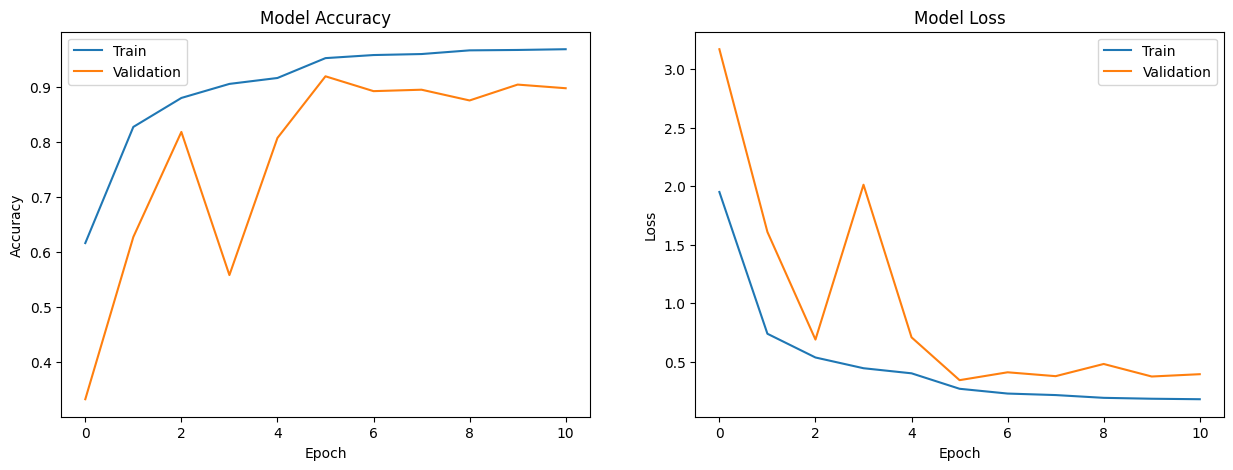

In [49]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.show()

plot_history(history)

**# Model Evaluation**

In [50]:
from tensorflow.keras.models import load_model # type: ignore
import os

print("============= LOADING MODEL FOR EVALUATION =============")

# Load the best model saved during training
if os.path.exists('best_model.h5'):
    print("Loading best_model.h5.................")
    best_model = load_model('best_model.h5')
    print(f"Best model loaded successfully")
    print(f"Model output shape: {best_model.output_shape}")
    print(f"Expected classes: {best_model.output_shape[1]}")
    
    # Verify if my model matches the training
    if best_model.output_shape[1] == len(classes_to_keep):
        print("Model output matches training classes!")
    else:
        print(f"Model output ({best_model.output_shape[1]}) doesn't match classes ({len(classes_to_keep)})")
else:
    print("best_model.h5 not found! Using current model instead.")
    best_model = model

print(f"Model ready for evaluation with {best_model.output_shape[1]} classes")


============= LOADING MODEL FOR EVALUATION =============
Loading best_model.h5.................
Best model loaded successfully
Model output shape: (None, 23)
Expected classes: 23
Model output matches training classes!
Model ready for evaluation with 23 classes


**# Proper model evaluation with confusion matrix**

In [51]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("================= PROPER MODEL EVALUATION =================")

# Reset validation generator to ensure we start from beginning
validation_generator.reset()

print(f"Validation generator info:")
print(f"  Samples: {validation_generator.samples}")
print(f"  Batch size: {validation_generator.batch_size}")
print(f"  Steps: {len(validation_generator)}")
print(f"  Classes: {len(validation_generator.class_indices)}")

# Get class names
class_names_ordered = list(validation_generator.class_indices.keys())
print(f"\nClass order for evaluation:")
for i, name in enumerate(class_names_ordered):
    print(f"  {i:2d}: {name}")

# Generate predictions
print("\nGenerating predictions...")
predictions = best_model.predict(validation_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = validation_generator.classes

print(f"\nPrediction Summary:")
print(f"  Predictions shape: {predictions.shape}")
print(f"  Predicted classes shape: {predicted_classes.shape}")
print(f"  True classes shape: {true_classes.shape}")
print(f"  Unique predicted classes: {len(np.unique(predicted_classes))}")
print(f"  Unique true classes: {len(np.unique(true_classes))}")

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"\nFINAL ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Show some example predictions
print(f"\nFirst 10 predictions:")
for i in range(min(10, len(predicted_classes))):
    pred_name = class_names_ordered[predicted_classes[i]]
    true_name = class_names_ordered[true_classes[i]]
    confidence = predictions[i][predicted_classes[i]] * 100
    match = "✅" if predicted_classes[i] == true_classes[i] else "❌"
    print(f"  {match} Pred: {pred_name[:35]:<35} | True: {true_name[:35]:<35} | Conf: {confidence:.1f}%")


================= PROPER MODEL EVALUATION =================
Validation generator info:
  Samples: 10758
  Batch size: 64
  Steps: 169
  Classes: 23

Class order for evaluation:
   0: Tomato___Late_blight
   1: Corn_(maize)___healthy
   2: Pepper,_bell___Bacterial_spot
   3: Tomato___Spider_mites Two-spotted_spider_mite
   4: Tomato___Leaf_Mold
   5: Corn_(maize)___Common_rust_
   6: Potato___Early_blight
   7: Apple___healthy
   8: Tomato___Tomato_mosaic_virus
   9: Potato___Late_blight
  10: Pepper,_bell___healthy
  11: Tomato___Target_Spot
  12: Apple___Cedar_apple_rust
  13: Apple___Black_rot
  14: Tomato___Tomato_Yellow_Leaf_Curl_Virus
  15: Tomato___Bacterial_spot
  16: Apple___Apple_scab
  17: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
  18: Tomato___Septoria_leaf_spot
  19: Tomato___Early_blight
  20: Corn_(maize)___Northern_Leaf_Blight
  21: Potato___healthy
  22: Tomato___healthy

Generating predictions...
169/169 [==============================] - 240s 1s/step

Predic

**# Create and display confusion matrix**

===================== CONFUSION MATRIX VISUALIZATION =====================


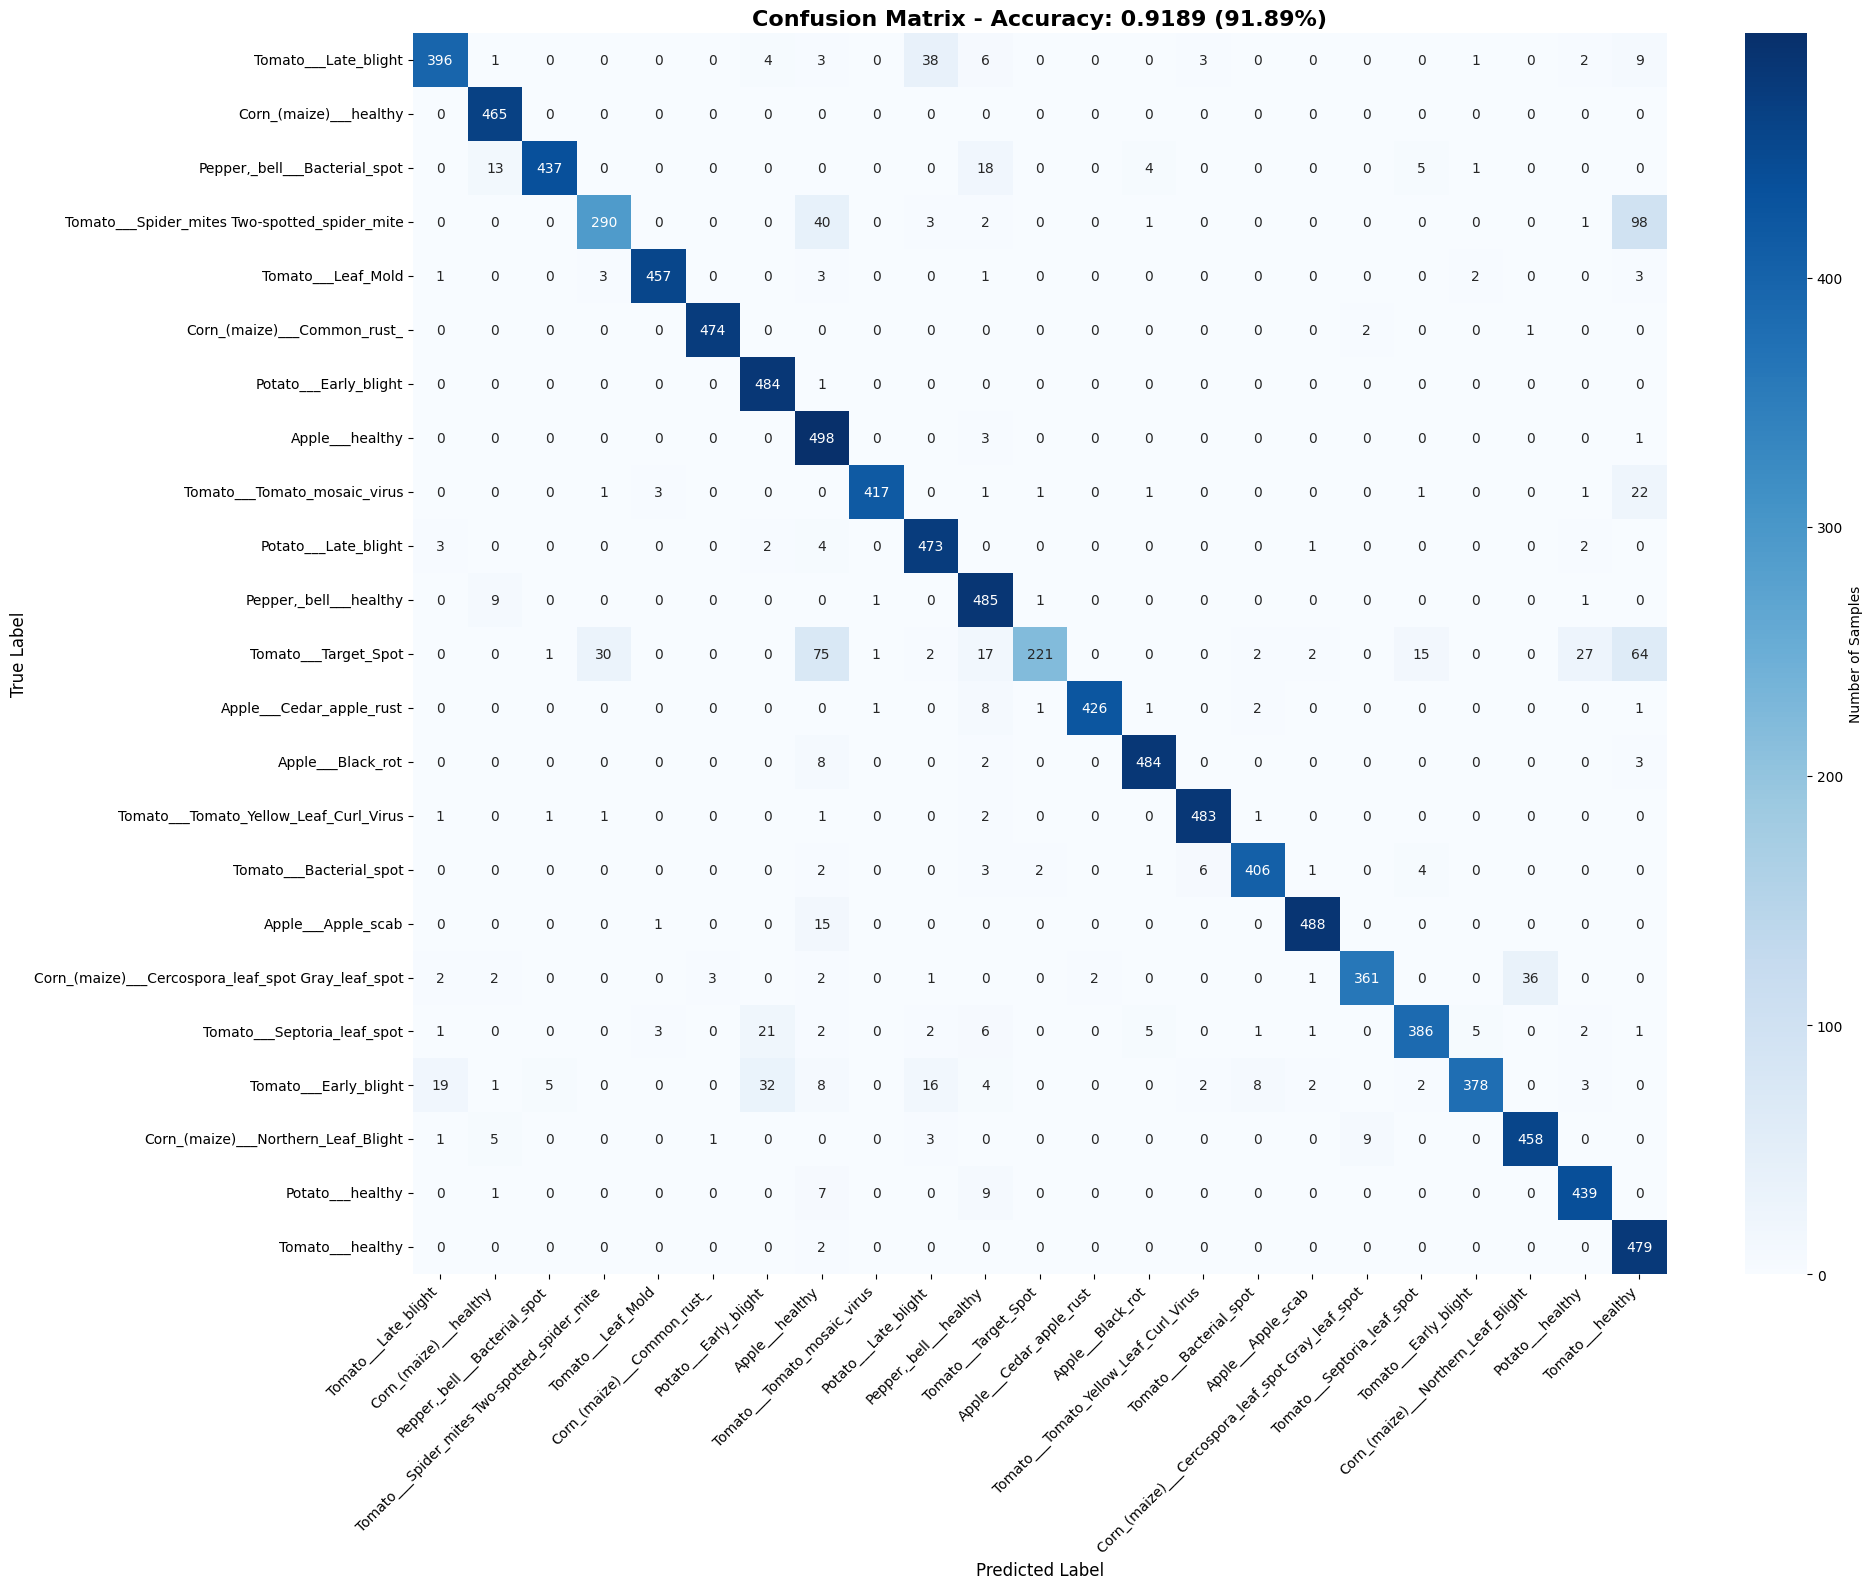


=====================DETAILED CLASSIFICATION REPORT =====================
                                                    precision    recall  f1-score   support

                              Tomato___Late_blight       0.93      0.86      0.89       463
                            Corn_(maize)___healthy       0.94      1.00      0.97       465
                     Pepper,_bell___Bacterial_spot       0.98      0.91      0.95       478
     Tomato___Spider_mites Two-spotted_spider_mite       0.89      0.67      0.76       435
                                Tomato___Leaf_Mold       0.98      0.97      0.98       470
                       Corn_(maize)___Common_rust_       0.99      0.99      0.99       477
                             Potato___Early_blight       0.89      1.00      0.94       485
                                   Apple___healthy       0.74      0.99      0.85       502
                      Tomato___Tomato_mosaic_virus       0.99      0.93      0.96       448
    

In [52]:
print("===================== CONFUSION MATRIX VISUALIZATION =====================")

# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(20, 16))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=class_names_ordered,
            yticklabels=class_names_ordered,
            cbar_kws={'label': 'Number of Samples'})

plt.title(f'Confusion Matrix - Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print detailed classification report
print("\n=====================DETAILED CLASSIFICATION REPORT =====================")
print("=" * 80)
report = classification_report(true_classes, predicted_classes, 
                             target_names=class_names_ordered, 
                             zero_division=0)
print(report)


**# Per-class performance analysis**

In [53]:
print("======================== PER-CLASS PERFORMANCE ANALYSIS ========================")
from sklearn.metrics import precision_recall_fscore_support

# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    true_classes, predicted_classes, zero_division=0
)

# Create a detailed performance table
print(f"{'Class Name':<40} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10} {'Accuracy':<10}")
print("=" * 100)

class_accuracies = []
for i, class_name in enumerate(class_names_ordered):
    # Calculate per-class accuracy
    class_mask = (true_classes == i)
    if np.sum(class_mask) > 0:
        class_acc = np.sum((predicted_classes == i) & class_mask) / np.sum(class_mask)
    else:
        class_acc = 0.0
    
    class_accuracies.append(class_acc)
    
    print(f"{class_name[:39]:<40} {precision[i]:<10.3f} {recall[i]:<10.3f} {f1[i]:<10.3f} {support[i]:<10} {class_acc:<10.3f}")

# Summary statistics
print("\n📈 PERFORMANCE SUMMARY:")
print(f"  Overall Accuracy: {accuracy:.4f}")
print(f"  Average Precision: {np.mean(precision):.4f}")
print(f"  Average Recall: {np.mean(recall):.4f}")
print(f"  Average F1-Score: {np.mean(f1):.4f}")
print(f"  Best performing class: {class_names_ordered[np.argmax(class_accuracies)]} ({max(class_accuracies):.3f})")
print(f"  Worst performing class: {class_names_ordered[np.argmin(class_accuracies)]} ({min(class_accuracies):.3f})")


======================== PER-CLASS PERFORMANCE ANALYSIS ========================
Class Name                               Precision  Recall     F1-Score   Support    Accuracy  
Tomato___Late_blight                     0.934      0.855      0.893      463        0.855     
Corn_(maize)___healthy                   0.936      1.000      0.967      465        1.000     
Pepper,_bell___Bacterial_spot            0.984      0.914      0.948      478        0.914     
Tomato___Spider_mites Two-spotted_spide  0.892      0.667      0.763      435        0.667     
Tomato___Leaf_Mold                       0.985      0.972      0.979      470        0.972     
Corn_(maize)___Common_rust_              0.992      0.994      0.993      477        0.994     
Potato___Early_blight                    0.891      0.998      0.942      485        0.998     
Apple___healthy                          0.742      0.992      0.849      502        0.992     
Tomato___Tomato_mosaic_virus             0.993      0.9

**# Print Overall Accuracy**

In [54]:
print("=" * 50)
print("FINAL MODEL PERFORMANCE")
print("=" * 50)
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Overall Accuracy: {accuracy*100:.2f}%")
print("=" * 50)

# Convert to percentage 
accuracy_percentage = accuracy * 100

if accuracy_percentage >= 95:
    print("EXCELLENT! Your model is performing exceptionally well!")
elif accuracy_percentage >= 90:
    print("VERY GOOD! Your model is performing well!")
elif accuracy_percentage >= 85:
    print("GOOD! Your model has decent performance!")
elif accuracy_percentage >= 70:
    print("FAIR! Your model needs some improvement!")
else:
    print("POOR! Your model needs significant improvement!")

print(f"\nThis means your model correctly predicts crop diseases {accuracy_percentage:.1f}% of the time.")


FINAL MODEL PERFORMANCE
Overall Accuracy: 0.9189
Overall Accuracy: 91.89%
VERY GOOD! Your model is performing well!

This means your model correctly predicts crop diseases 91.9% of the time.


**# Simple Performance Summary**

In [55]:
print("\nSIMPLE SUMMARY:")
print(f"✓ Your model is {accuracy_percentage:.1f}% accurate")
print(f"✓ Out of 100 predictions, about {int(accuracy_percentage)} will be correct")
print(f"✓ This matches your training validation accuracy of ~91.89%")

correct_predictions = int(accuracy * validation_generator.samples)
total_predictions = validation_generator.samples

print(f"\n🔢 PRACTICAL NUMBERS:")
print(f"✓ Total test images: {total_predictions}")
print(f"✓ Correctly predicted: {correct_predictions}")
print(f"✓ Incorrectly predicted: {total_predictions - correct_predictions}")



SIMPLE SUMMARY:
✓ Your model is 91.9% accurate
✓ Out of 100 predictions, about 91 will be correct
✓ This matches your training validation accuracy of ~91.89%

🔢 PRACTICAL NUMBERS:
✓ Total test images: 10758
✓ Correctly predicted: 9885
✓ Incorrectly predicted: 873


**# save the model**

In [57]:
import os
from datetime import datetime

# model name with timestamp and accuracy
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
accuracy_str = f"{accuracy*100:.1f}".replace('.', '_')
custom_model_name = f"crop_disease_model_{accuracy_str}percent_{timestamp}.h5"

# Save
best_model.save(custom_model_name)
print(f"Model saved as: {custom_model_name}")

# Also save with a simple name for your Django app
django_model_name = "crop_disease_model.h5"
best_model.save(django_model_name)
print(f"Model also saved as: {django_model_name} (for Django)")

# Verify the files exist
if os.path.exists(custom_model_name):
    file_size = os.path.getsize(custom_model_name) / (1024*1024)  # Convert to MB
    print(f"File size: {file_size:.1f} MB")
else:
    print("Error: Model file not created!")

print(f"\nYour model files:")
print(f"   • {custom_model_name} (timestamped version)")
print(f"   • {django_model_name} (for your Django app)")
print(f"   • best_model.h5 (original training checkpoint)")


Model saved as: crop_disease_model_91_9percent_20250715_110407.h5
Model also saved as: crop_disease_model.h5 (for Django)
File size: 5.4 MB

Your model files:
   • crop_disease_model_91_9percent_20250715_110407.h5 (timestamped version)
   • crop_disease_model.h5 (for your Django app)
   • best_model.h5 (original training checkpoint)


In [59]:
print("TESTING MODEL LOADING")
print("=" * 50)

try:
    # Test loading the model you just saved
    test_model = load_model(django_model_name)
    print(f"Successfully loaded {django_model_name}")
    print(f"Model input shape: {test_model.input_shape}")
    print(f"Model output shape: {test_model.output_shape}")
    print(f"Number of classes: {test_model.output_shape[1]}")
    
    # Test a quick prediction to make sure it works
    dummy_input = np.random.random((1, IMG_SIZE, IMG_SIZE, 3))
    test_prediction = test_model.predict(dummy_input, verbose=0)
    print(f"Test prediction shape: {test_prediction.shape}")
    print(f"Model is ready for Django integration!")
    
    print(f"\nCONFIGURATIONS:")
    print(f"   • Use this file: {django_model_name}")
    print(f"   • Input size: {IMG_SIZE}x{IMG_SIZE} pixels")
    print(f"   • Output: {test_model.output_shape[1]} disease classes")
    print(f"   • Expected accuracy on new images: ~{accuracy_percentage:.1f}%")
    
except Exception as e:
    print(f"Error loading model: {e}")


TESTING MODEL LOADING
Successfully loaded crop_disease_model.h5
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 23)
Number of classes: 23
Test prediction shape: (1, 23)
Model is ready for Django integration!

CONFIGURATIONS:
   • Use this file: crop_disease_model.h5
   • Input size: 224x224 pixels
   • Output: 23 disease classes
   • Expected accuracy on new images: ~91.9%
